In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time
import os
from sklearn.metrics import silhouette_score
import umap
from matplotlib.colors import ListedColormap

In [ ]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_combined_stc_z = pd.read_csv(os.path.join(folder_path, "features_combined_stc_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_combined_stc_mm= pd.read_csv(os.path.join(folder_path, "features_combined_stc_minmax.csv"))

#se quitan las columnas 'filename' y 'label'
df_combined_stc_mm_cl= df_combined_stc_mm.drop(columns=['label', 'filename'])
df_combined_stc_z_cl= df_combined_stc_z.drop(columns=['label', 'filename'])


In [26]:
df_combined_stc_mm_cl

,eccentricity,solidity,major_axis_length,hue,brightness,saturation,contrast,homogeneity,correlation
0,0.840083,0.749355,0.358292,0.173814,-0.258016,-0.908055,0.180035,0.849470,0.834112
1,0.841452,0.441238,0.592452,3.173069,1.450514,-2.630162,0.108787,0.916683,0.789212
2,0.660993,0.939005,0.262267,-0.718451,-0.160670,0.927561,0.284960,0.711725,0.663472
3,0.719967,0.879431,0.338620,-0.373024,0.338521,0.458052,0.210377,0.713113,0.698357
4,0.459722,0.929210,0.105664,-0.064264,-0.045647,0.141367,0.357567,0.562984,0.532437
...,...,...,...,...,...,...,...,...,...
532,0.470665,0.624936,0.598448,0.893369,0.602273,-0.410392,0.160144,0.887216,0.875368
533,0.375058,0.735823,0.596513,0.014286,-0.105928,0.361934,0.205163,0.913790,0.833322
534,0.638007,0.678224,0.639816,1.284708,0.114134,-0.041958,0.182547,0.834166,0.862728
535,0.534958,0.481038,0.657953,2.768508,1.430725,-1.294443,0.138639,0.984693,0.899824


Primero se realizará el clustering k-medoids con los datos normalizados ocn z-score

In [27]:
def _get_init_centers(n_clusters, n_samples):
    '''Return random unique indices as initial medoid centers'''
    return np.random.choice(n_samples, size=n_clusters, replace=False).tolist()

def _get_distance(data1, data2):
    '''Euclidean distance function'''
    return np.sqrt(np.sum((data1 - data2) ** 2))

def _get_cost(X, centers_id, dist_func):
    '''Return members, per-cluster costs, total cost, and distance matrix'''
    dist_mat = np.zeros((len(X), len(centers_id)))
    for j, center_id in enumerate(centers_id):
        center = X[center_id, :]
        for i in range(len(X)):
            if i == center_id:
                dist_mat[i, j] = 0.
            else:
                dist_mat[i, j] = dist_func(X[i, :], center)

    mask = np.argmin(dist_mat, axis=1)
    members = mask.copy()
    costs = np.array([np.sum(dist_mat[mask == i, i]) for i in range(len(centers_id))])
    return members, costs, np.sum(costs), dist_mat

def _kmedoids_run(X, n_clusters, dist_func, max_iter=1000, tol=0.001, verbose=True):
    n_samples = X.shape[0]
    centers = _get_init_centers(n_clusters, n_samples)
    if verbose:
        print("Initial centers are", centers)

    members, costs, tot_cost, dist_mat = _get_cost(X, centers, dist_func)
    cc, swapped = 0, True

    while swapped and cc < max_iter:
        swapped = False
        for i in range(n_samples):
            if i not in centers:
                for j in range(len(centers)):
                    new_centers = deepcopy(centers)
                    new_centers[j] = i
                    members_, costs_, tot_cost_, dist_mat_ = _get_cost(X, new_centers, dist_func)
                    if tot_cost - tot_cost_ > tol:
                        members, costs, tot_cost, dist_mat = members_, costs_, tot_cost_, dist_mat_
                        centers = new_centers
                        swapped = True
                        if verbose:
                            print("Change centers to", centers)
        cc += 1

    if verbose:
        if not swapped:
            print("End Searching by no swaps")
        else:
            print("End Searching by reaching maximum iteration", max_iter)

    return centers, members, costs, tot_cost, dist_mat, cc

class KMedoids:
    '''
    K-Medoids Clustering (PAM) Algorithm

    Parameters
    ----------
    n_clusters : int
        Number of clusters
    dist_func : callable
        Distance function (default: Euclidean)
    max_iter : int
        Maximum number of iterations
    tol : float
        Tolerance to stop swapping
    '''
    def __init__(self, n_clusters, dist_func=_get_distance, max_iter=1000, tol=0.001):
        self.n_clusters = n_clusters
        self.dist_func = dist_func
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X, plotit=True, verbose=True):
        self.X_train = X
        result = _kmedoids_run(
            X, self.n_clusters, self.dist_func, self.max_iter, self.tol, verbose
        )
        self.centers_, self.labels_, self.costs_, self.total_cost_, self.dist_mat_, self.n_iter_ = result

        if plotit and X.shape[1] == 2:
            self._plot_clusters(X)
        elif plotit:
            print("Plotting only supported for 2D data.")

    def predict(self, X):
        if not hasattr(self, "centers_"):
            raise RuntimeError("Model has not been fitted.")
        labels = np.zeros(len(X), dtype=int)
        for i, x in enumerate(X):
            dists = [self.dist_func(x, self.X_train[c]) for c in self.centers_]
            labels[i] = np.argmin(dists)
        return labels

    def _plot_clusters(self, X):
        plt.figure(figsize=(8, 6))
        cmap = plt.get_cmap('tab10')
        for i in range(self.n_clusters):
            cluster_points = X[self.labels_ == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                        color=cmap(i), alpha=0.5, label=f'Cluster {i}')
            plt.scatter(X[self.centers_[i], 0], X[self.centers_[i], 1],
                        color=cmap(i), marker='*', s=300, edgecolor='k')
        plt.title("K-Medoids Clustering")
        plt.legend()
        plt.grid(True)
        plt.show()

Initial centers are [236, 186, 376]
Change centers to [236, 0, 376]
Change centers to [9, 0, 376]
Change centers to [19, 0, 376]
Change centers to [19, 24, 376]
Change centers to [19, 25, 376]
Change centers to [19, 25, 28]
Change centers to [19, 25, 33]
Change centers to [19, 83, 33]
Change centers to [19, 99, 33]
Change centers to [113, 99, 33]
Change centers to [113, 99, 124]
Change centers to [113, 135, 124]
Change centers to [145, 135, 124]
Change centers to [162, 135, 124]
Change centers to [170, 135, 124]
Change centers to [170, 135, 268]
Change centers to [170, 135, 469]
Change centers to [170, 135, 470]
Change centers to [170, 528, 470]
End Searching by no swaps
Etiquetas únicas: [0 1 2]


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


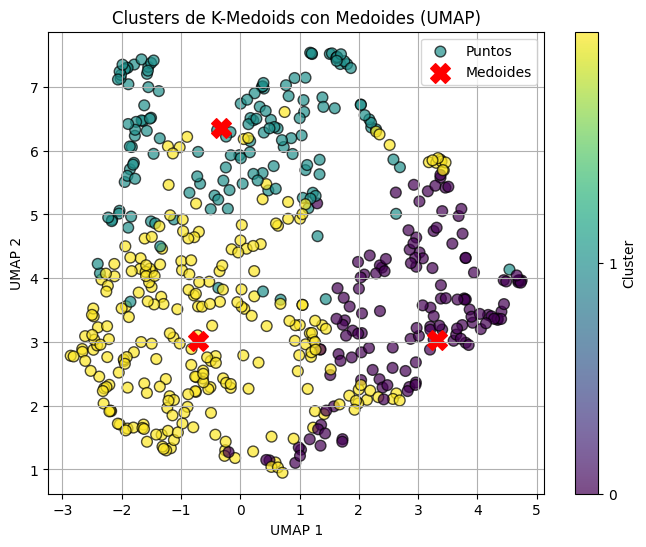

In [28]:
X = df_combined_stc_z_cl.to_numpy()

# Crear modelo K-Medoids 
model = KMedoids(n_clusters=3)
model.fit(X, plotit=False)

# Verifica que solo haya 2 etiquetas
print("Etiquetas únicas:", np.unique(model.labels_))

# Reducir dimensionalidad a 2D con UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_2D = umap_model.fit_transform(X)

# Transformar coordenadas de los medoides al espacio 2D
medoids_2D = umap_model.transform(X[model.centers_])

# Graficar los clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2D[:, 0], X_2D[:, 1],
    c=model.labels_,
    s=60,
    edgecolor='k',
    alpha=0.7,
    label="Puntos"
)

# Graficar medoides
plt.scatter(
    medoids_2D[:, 0], medoids_2D[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Medoides'
)

# Detalles de la gráfica
plt.title("Clusters de K-Medoids con Medoides (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, ticks=[0, 1], label="Cluster")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
silhouette = silhouette_score(X, model.labels_)
print(f"Silhouette Score: {silhouette:.4f}")

Silhouette Score: 0.1850


In [30]:
y_true = df_combined_stc_z['label']  

# Etiquetas predichas por K-Medoids
y_pred = model.labels_

# Tabla de contingencia
contingency_table = pd.crosstab(y_true, y_pred, rownames=['Etiqueta Real'], colnames=['Cluster K-Medoids'])
print("Tabla de Contingencia:")
print(contingency_table)

Tabla de Contingencia:
Cluster K-Medoids    0   1    2
Etiqueta Real                  
higher               2  87  179
smaller            135  63   71


In [34]:
# Crear DataFrame de resultados K-Medoids
df_resultado_kmedoids = pd.DataFrame({
    'filename': df_combined_stc_z['filename'],
    'label': df_combined_stc_z['label'],
    'cluster': model.labels_
})

# Mostrar las primeras filas para verificar
print(df_resultado_kmedoids.head())

# Guardar a CSV
#df_resultado_kmedoids.to_csv(os.path.join(folder_path, 'resultado_kmedoids_z_umap.csv'), index=False)


        filename    label  cluster
0    callo_1.png  smaller        1
1   callo_10.png  smaller        1
2  callo_100.png  smaller        0
3  callo_101.png  smaller        0
4  callo_102.png  smaller        0


2 clusteres: El 97.38% de las imágenes higher están en el cluster 1 y solo el 33.88% de las smaller enel cluster 0.
Con tres clusteres: el 66.79% de las imágenes higher están en el cluster 1, el 50.18% de las smaller en el cluster 2, y hay un tercer cluster con mezcla.

Se hace lo mismo pero con la nomralización min-máx

Initial centers are [244, 360, 87]
Change centers to [244, 0, 87]
Change centers to [2, 0, 87]
Change centers to [2, 5, 87]
Change centers to [2, 6, 87]
Change centers to [18, 6, 87]
Change centers to [33, 6, 87]
Change centers to [33, 6, 99]
Change centers to [303, 6, 99]
Change centers to [304, 6, 99]
End Searching by no swaps
Etiquetas únicas: [0 1 2]


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


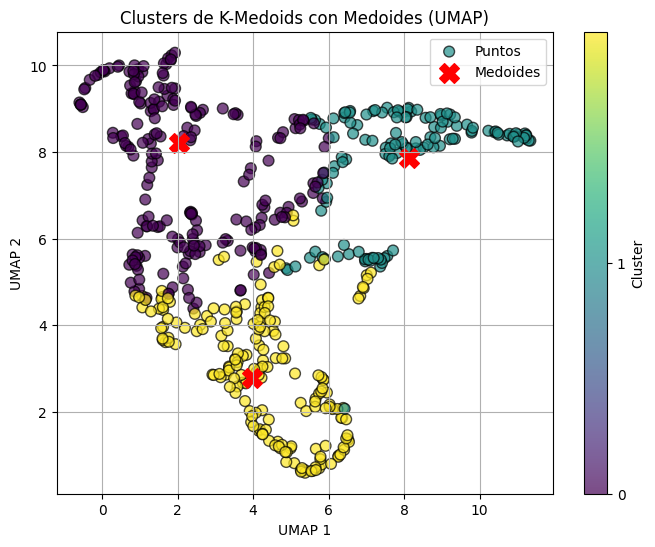

In [31]:
X_mm = df_combined_stc_mm_cl.to_numpy()

# Crear modelo K-Medoids 
model_mm = KMedoids(n_clusters=3)
model_mm.fit(X_mm, plotit=False)

# Verifica que solo haya 2 etiquetas
print("Etiquetas únicas:", np.unique(model_mm.labels_))

# Reducir dimensionalidad a 2D con UMAP
umap_model_mm = umap.UMAP(n_neighbors=10,n_components=2, random_state=42)
X_2D_mm = umap_model_mm.fit_transform(X_mm)

# Transformar coordenadas de los medoides al espacio 2D
medoids_2D_mm = umap_model_mm.transform(X_mm[model_mm.centers_])

# Graficar los clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2D_mm[:, 0], X_2D_mm[:, 1],
    c=model_mm.labels_,
    s=60,
    edgecolor='k',
    alpha=0.7,
    label="Puntos"
)

# Graficar medoides
plt.scatter(
    medoids_2D_mm[:, 0], medoids_2D_mm[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Medoides'
)

# Detalles de la gráfica
plt.title("Clusters de K-Medoids con Medoides (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, ticks=[0, 1], label="Cluster")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
silhouette_mm = silhouette_score(X_mm, model_mm.labels_)
print(f"Silhouette Score: {silhouette_mm:.4f}")

Silhouette Score: 0.3056


In [33]:
y_true = df_combined_stc_mm['label']  

# Etiquetas predichas por K-Medoids
y_pred = model_mm.labels_

# Tabla de contingencia
contingency_table_mm = pd.crosstab(y_true, y_pred, rownames=['Etiqueta Real'], colnames=['Cluster K-Medoids'])
print("Tabla de Contingencia:")
print(contingency_table_mm)

Tabla de Contingencia:
Cluster K-Medoids    0   1    2
Etiqueta Real                  
higher             132  55   81
smaller             82  78  109


In [36]:
# Crear DataFrame de resultados K-Medoids
df_resultado_kmedoids_mm = pd.DataFrame({
    'filename': df_combined_stc_mm['filename'],
    'label': df_combined_stc_mm['label'],
    'cluster': model.labels_
})

# Mostrar las primeras filas para verificar
print(df_resultado_kmedoids_mm.head())

#  Guardar a CSV
#df_resultado_kmedoids_mm.to_csv(os.path.join(folder_path, 'resultado_kmedoids_mm_umap.csv'), index=False)


        filename    label  cluster
0    callo_1.png  smaller        1
1   callo_10.png  smaller        1
2  callo_100.png  smaller        0
3  callo_101.png  smaller        0
4  callo_102.png  smaller        0


Con dos clusteres el 77,6% de las imágenes etiquetads como higher están en el cluster 1. Las imágenes etiquetadas como smaller estarían repartidas entre los clusters 0 y 1.
Si se establecen 3 clusteres, el cluster 1 estrá compuesto por: 49.25% de imagenes higher y 40.52% de imágenes smaller.
El cluster 2: 30.22% de imágenes higher y 40.52% de smaller. El cluster 0: 20.44% de higher y 28.99% de smaller.
Los tres clusteres estarían equilibrados.